<a href="https://colab.research.google.com/github/lrobsky/Weather-prediction/blob/main/Weather_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from google.colab import files

In [ ]:
#@title Upload london_weather.csv here
uploaded = files.upload()

Saving london_weather.csv to london_weather.csv


In [ ]:
data = pd.read_csv('london_weather.csv')

In [ ]:
#@title Function to fill in missing values
def fill_in_missing(feature_name):
    # Calculate the average of the two values above and below the missing value
    data[feature_name + "_filled"] = data[feature_name].fillna(
        (data[feature_name].shift(1) + data[feature_name].shift(2)
        + data[feature_name].shift(-1) + data[feature_name].shift(-2)) / 4
    )

    # Drop old feature column, replace with the new one that filled the NaN values
    data.drop([feature_name], axis = 1, inplace = True)
    data.rename(columns = {feature_name + "_filled": feature_name}, inplace=True)

We found that there are missing values for some features.
We decided to fill these missing values with an average of the previous 2 days and of the 2 days after.
In example, if c is the missing value and a,b are the values of the two days before and d,e are the 2 days after,
c = (a+b+d+e)/4

In [ ]:
# # Uncomment to drop all rows with missing columns.
# data.dropna(inplace=True)
# data

In [ ]:
#converting the date for better visibility, will help if we'll need to extract data from range of dates
data['date'] = pd.to_datetime(data['date'],format='%Y%m%d')
data.set_index('date', inplace=True)
data

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...
2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN


In [ ]:
#@title Fill all features
for feature in data.columns:
    fill_in_missing(feature)
data

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...
2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN


In [ ]:
data = data.fillna(data.median())
data

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...
2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,0.0
2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,0.0
2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,0.0


In [ ]:
#@title Check if everything is filled
for feature in data.columns:
  print(f"Are all NA values for {feature} filled?", data[feature].isnull().sum() == 0)

Are all NA values for cloud_cover filled? True
Are all NA values for sunshine filled? True
Are all NA values for global_radiation filled? True
Are all NA values for max_temp filled? True
Are all NA values for mean_temp filled? True
Are all NA values for min_temp filled? True
Are all NA values for precipitation filled? True
Are all NA values for pressure filled? True
Are all NA values for snow_depth filled? True


In [ ]:
#uncomment to select specific features
# data = data[['date','cloud_cover','sunshine','global_radiation','max_temp','mean_temp','min_temp','precipitation','pressure','snow_depth']]
# data


In [ ]:
#@title call MinMaxScaler
scaler = MinMaxScaler()
data[:] = scaler.fit_transform(data)
data

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,0.222222,0.43750,0.111675,0.192744,0.095628,0.126100,0.006472,0.670429,0.409091
1979-01-02,0.666667,0.10625,0.048223,0.176871,0.136612,0.126100,0.000000,0.741535,0.363636
1979-01-03,0.555556,0.00000,0.012690,0.170068,0.131148,0.134897,0.000000,0.687359,0.181818
1979-01-04,0.888889,0.00000,0.012690,0.133787,0.136612,0.155425,0.000000,0.550790,0.090909
1979-01-05,0.666667,0.12500,0.053299,0.267574,0.185792,0.304985,0.000000,0.709932,0.045455
...,...,...,...,...,...,...,...,...,...
2020-12-27,0.111111,0.05625,0.060914,0.310658,0.412568,0.568915,0.032362,0.230248,0.000000
2020-12-28,0.777778,0.23125,0.076142,0.222222,0.237705,0.307918,0.003236,0.159142,0.000000
2020-12-29,0.777778,0.00000,0.032995,0.233560,0.278689,0.378299,0.000000,0.323928,0.000000


In [ ]:
#@title Hyperparameters
learning_rate = 0.01
num_epochs = 30
batch_size = 20
input_size = 9 # number of features, can also be data.shape[1]
hidden_size = 32
num_layers = 1
bidirectional = False
split_percent = 0.8
shuffle = True
lookback = 7
dropout = 0

In [ ]:
#@title Create sequential data


def create_sequences(df, lookback):
    # create deep copy for clarity
    df = dc(df)
    # convert dataframe to 2D array
    X = df.values

    # will store sequences
    # a sequence is of shape (lookback,num_of_features), where each row holds the weather data of a specific day in the sequence.
    #e.g if for example we are predicting the temperature for the date '2018-12-10', then the first row will hold the data for the date '2018-12-09', the second row for '2018-12-08', etc..
    sequences = []

    # create sequence for each row
    for i in range(len(df) - lookback):
        sequence = X[i : i + lookback]
        sequences.append(sequence)


    # convert the list into a 3D numpy array and return it
    return np.array(sequences)

# We will do our prediction based on the previous 7 days data
sequence_data = create_sequences(data, lookback)
sequence_data.shape

(15334, 7, 9)

In [ ]:
#drop first few rows that you create a sequence for.
selected_columns = ['mean_temp', 'pressure']
features_prediction = data[selected_columns][lookback:].values
sequence_data.shape,features_prediction.shape

((15334, 7, 9), (15334, 2))

In [ ]:
#flip rows so that last (7th for our case) day will enter LSTM first
sequence_data = dc(np.flip(sequence_data, axis=1))

In [ ]:
#@title CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#@title Train&Test split
# split_percent train, 1 - split_percent test
split_index = int(len(sequence_data) * split_percent)
X_train = sequence_data[:split_index]
X_test = sequence_data[split_index:]

y_train = features_prediction[:split_index]
y_test = features_prediction[split_index:]
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((12267, 7, 9), (3067, 7, 9), (12267, 2), (3067, 2))

In [ ]:
#@title convert to Tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([12267, 7, 9]),
 torch.Size([3067, 7, 9]),
 torch.Size([12267, 2]),
 torch.Size([3067, 2]))

In [ ]:
#@title LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional = False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)

        self.fc = nn.Linear(hidden_size * self.num_directions, 2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :].squeeze(1))
        return out

In [ ]:
#@title load into DataLoader
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
#@title Training function
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')

    # So we can print between batches and epochs
    running_loss_batch = 0.0
    running_loss_epoch = 0.0
    print_every = 100
    batch_counter = 0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)

        running_loss_batch += loss.item()
        running_loss_epoch += loss.item()

        batch_counter += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_counter % print_every == 0:
            avg_loss_per_batch = running_loss_batch / print_every
            print(f'Batch {batch_counter}, Loss: {avg_loss_per_batch:.3f}')
            running_loss_batch = 0.0  # Reset running loss for the next set of batches

    # Calculate the average loss for the epoch after all batches are processed
    epoch_loss = running_loss_epoch / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Train Loss: {epoch_loss:.3f}\n')

In [ ]:
#@title Testing function
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    test_losses.append(avg_loss_across_batches)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
#@title Training and Testing Loop
model = LSTM(input_size,hidden_size, num_layers,bidirectional)
model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.022
Batch 200, Loss: 0.011
Batch 300, Loss: 0.010
Batch 400, Loss: 0.009
Batch 500, Loss: 0.006
Batch 600, Loss: 0.005
Train Loss: 0.010

Val Loss: 0.005
***************************************************

Epoch: 2
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004
Batch 300, Loss: 0.004
Batch 400, Loss: 0.004
Batch 500, Loss: 0.003
Batch 600, Loss: 0.003
Train Loss: 0.004

Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.003
Batch 400, Loss: 0.003
Batch 500, Loss: 0.003
Batch 600, Loss: 0.003
Train Loss: 0.003

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.003
Batch 400, Loss: 0.003
Batch 500, Loss: 0.003
Batch 600, Loss: 0.003
Train Loss: 0.003

Val Loss: 0.003
***************************************************

Epoch: 5
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch

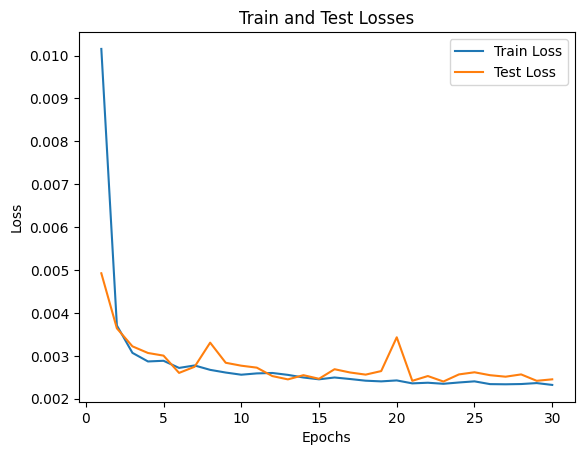

In [ ]:
#@title Losses plots
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()

plt.show()

In [ ]:
with torch.no_grad():
    test_predictions = model(X_test).cpu().numpy()
    train_predictions = model(X_train).cpu().numpy()

In [ ]:
#@title Convert datasets to numpy arrays.
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()
X_train = X_train.cpu().numpy()
X_test = X_test.cpu().numpy()


In [ ]:
#@title Inverse test predictions
#before we can call inverse_transform we first must pad our prediction vector to size (num_of_test_samples,num_of_features)

# Inverse temp predictions
index = data.columns.get_loc('mean_temp')
dummies = np.zeros((X_test.shape[0], data.shape[1]))
dummies[:, index] = test_predictions[:,0]
dummies = scaler.inverse_transform(dummies)

temperature_predictions = dummies[:, index]

# Inverse mean_temp_test
dummies = np.zeros((X_test.shape[0], data.shape[1]))
dummies[:, index] = y_test[:,0]
dummies = scaler.inverse_transform(dummies)

actual_mean_temp_test = dummies[:, index]

#Inverse pressure predictions
index = data.columns.get_loc('pressure')

dummies = np.zeros((X_test.shape[0], data.shape[1]))
dummies[:, index] = test_predictions[:,1]
dummies = scaler.inverse_transform(dummies)

pressure_predictions = dummies[:, index]

dummies = np.zeros((X_test.shape[0], data.shape[1]))
dummies[:, index] = y_test[:,1]
dummies = scaler.inverse_transform(dummies)

actual_pressure_test = dummies[:, index]

In [ ]:
#@title Inverse train predictions
index = data.columns.get_loc('mean_temp')
dummies = np.zeros((X_train.shape[0], data.shape[1]))
dummies[:, index] = train_predictions[:,0]
dummies = scaler.inverse_transform(dummies)

temperature_predictions_train = dummies[:, index]

# Inverse mean_temp_train
dummies = np.zeros((X_train.shape[0], data.shape[1]))
dummies[:, index] = y_train[:,0]
dummies = scaler.inverse_transform(dummies)

actual_mean_temp_train = dummies[:, index]

# Inverse pressure train data
index = data.columns.get_loc('pressure')

dummies = np.zeros((X_train.shape[0], data.shape[1]))
dummies[:, index] = train_predictions[:,1]
dummies = scaler.inverse_transform(dummies)

pressure_predictions_train = dummies[:, index]

dummies = np.zeros((X_train.shape[0], data.shape[1]))
dummies[:, index] = y_train[:,1]
dummies = scaler.inverse_transform(dummies)

actual_pressure_train = dummies[:, index]

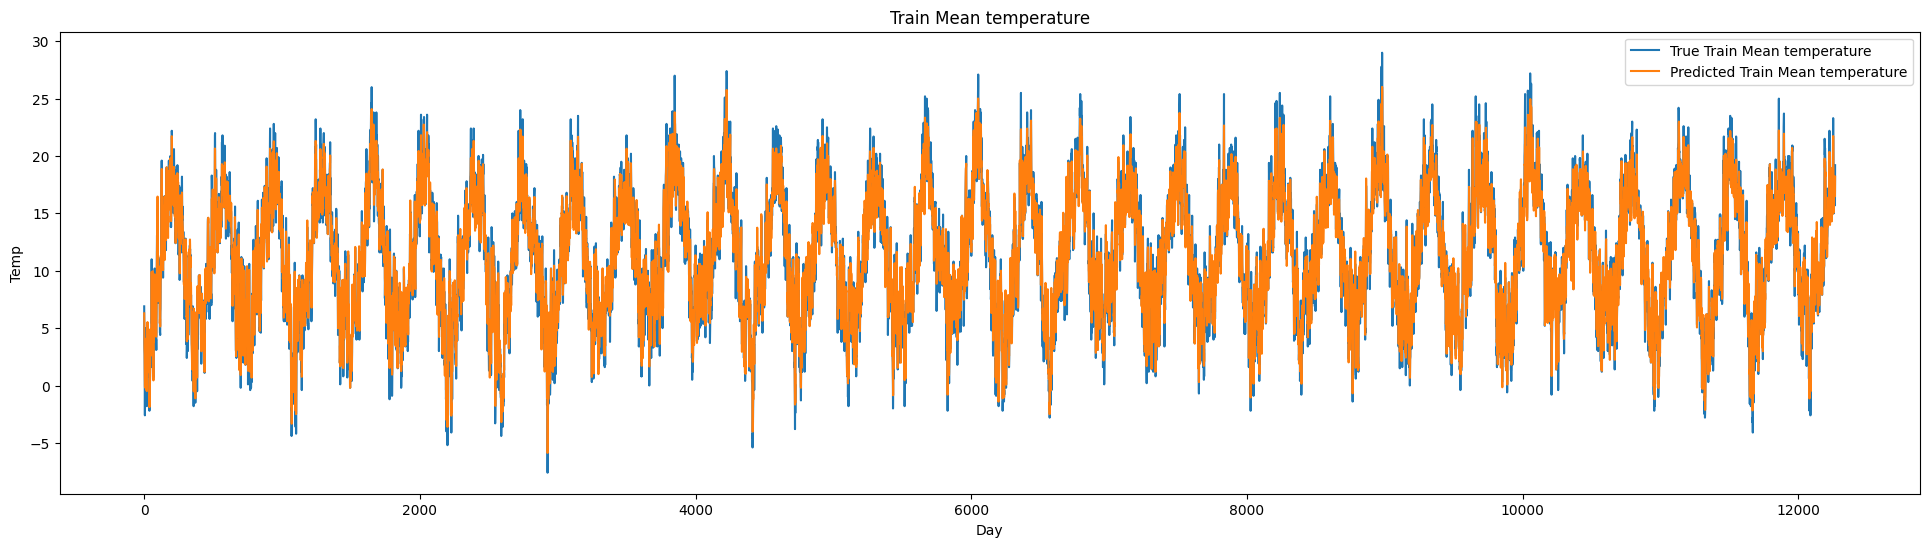

In [ ]:
#@title Plot temperature train predictions
plt.figure(figsize=(24, 6))
plt.plot(actual_mean_temp_train, label='True Train Mean temperature')
plt.plot(temperature_predictions_train, label='Predicted Train Mean temperature')
plt.title("Train Mean temperature")
plt.xlabel('Day')
plt.ylabel('Temp')
plt.legend()
plt.show()


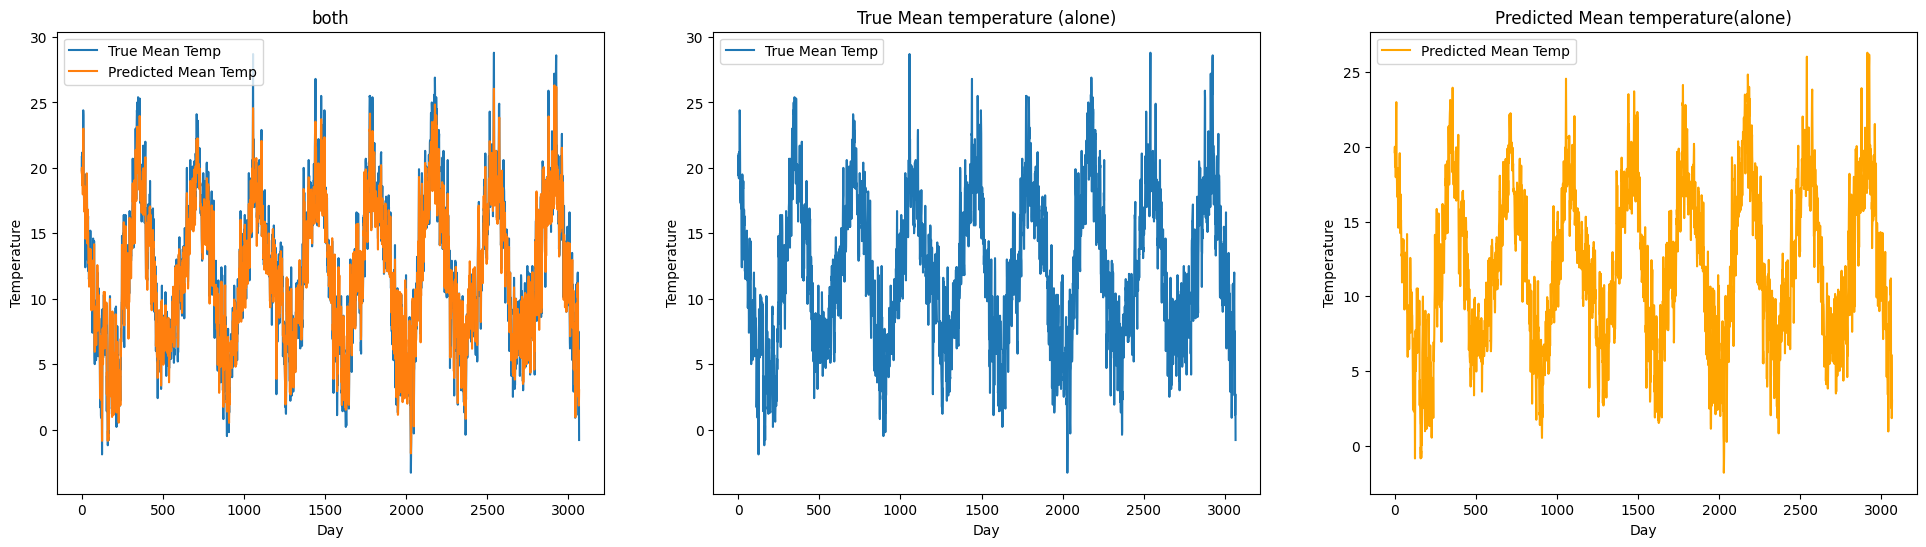

In [ ]:
#@title Test temperature predictions
plt.figure(figsize=(24, 6))

plt.subplot(131)
plt.title("both")
plt.plot(actual_mean_temp_test, label='True Mean Temp')
plt.plot(temperature_predictions, label='Predicted Mean Temp')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()

plt.subplot(132)
plt.title("True Mean temperature (alone)")
plt.plot(actual_mean_temp_test, label='True Mean Temp')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()

plt.subplot(133)
plt.title("Predicted Mean temperature(alone)")
plt.plot(temperature_predictions, label='Predicted Mean Temp',color='orange')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()

plt.show()

In [ ]:
#@title Mean temperature prediction metrics
print("Mean temperature stats:")

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(temperature_predictions - actual_mean_temp_test))
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = np.mean((temperature_predictions - actual_mean_temp_test) ** 2)
print("Mean Squared Error (MSE):", mse)
print("Square root of the MSE is:", np.sqrt(mse))

# Calculate Mean Absolute Percentage Error (MAPE) with epsilon
epsilon = 1e-10

mape = np.mean(np.abs((temperature_predictions - actual_mean_temp_test) / (actual_mean_temp_test + epsilon))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean temperature stats:
Mean Absolute Error (MAE): 0.9100023742695954
Mean Squared Error (MSE): 1.4190741842168024
Square root of the MSE is: 1.1912490017694883
Mean Absolute Percentage Error (MAPE): 12.529536710323146


In [ ]:
index = data.columns.get_loc('pressure')

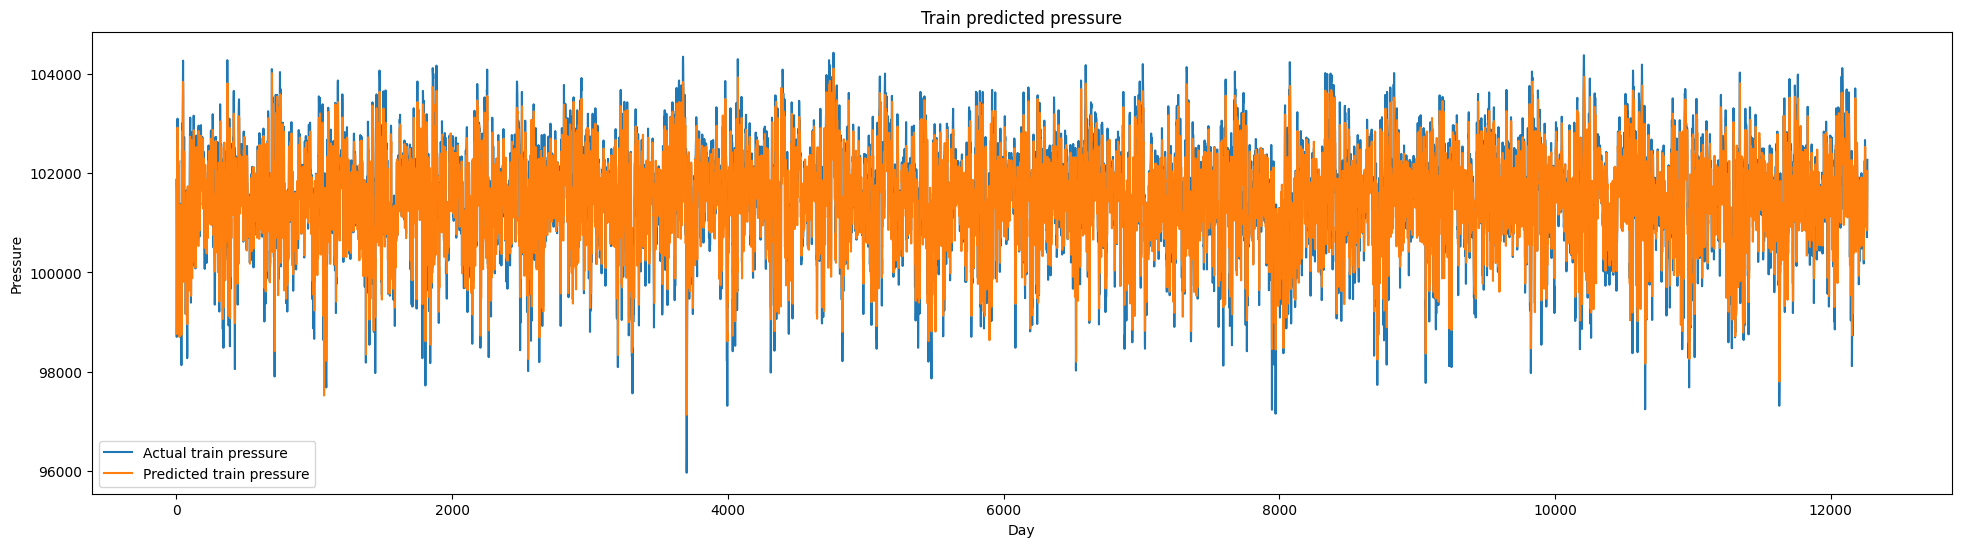

In [ ]:
#@title Pressure train predictions


plt.figure(figsize=(24, 6))
plt.title("Train predicted pressure")
plt.plot(actual_pressure_train, label='Actual train pressure')
plt.plot(pressure_predictions_train, label='Predicted train pressure')
plt.xlabel('Day')
plt.ylabel('Pressure')
plt.legend()
plt.show()

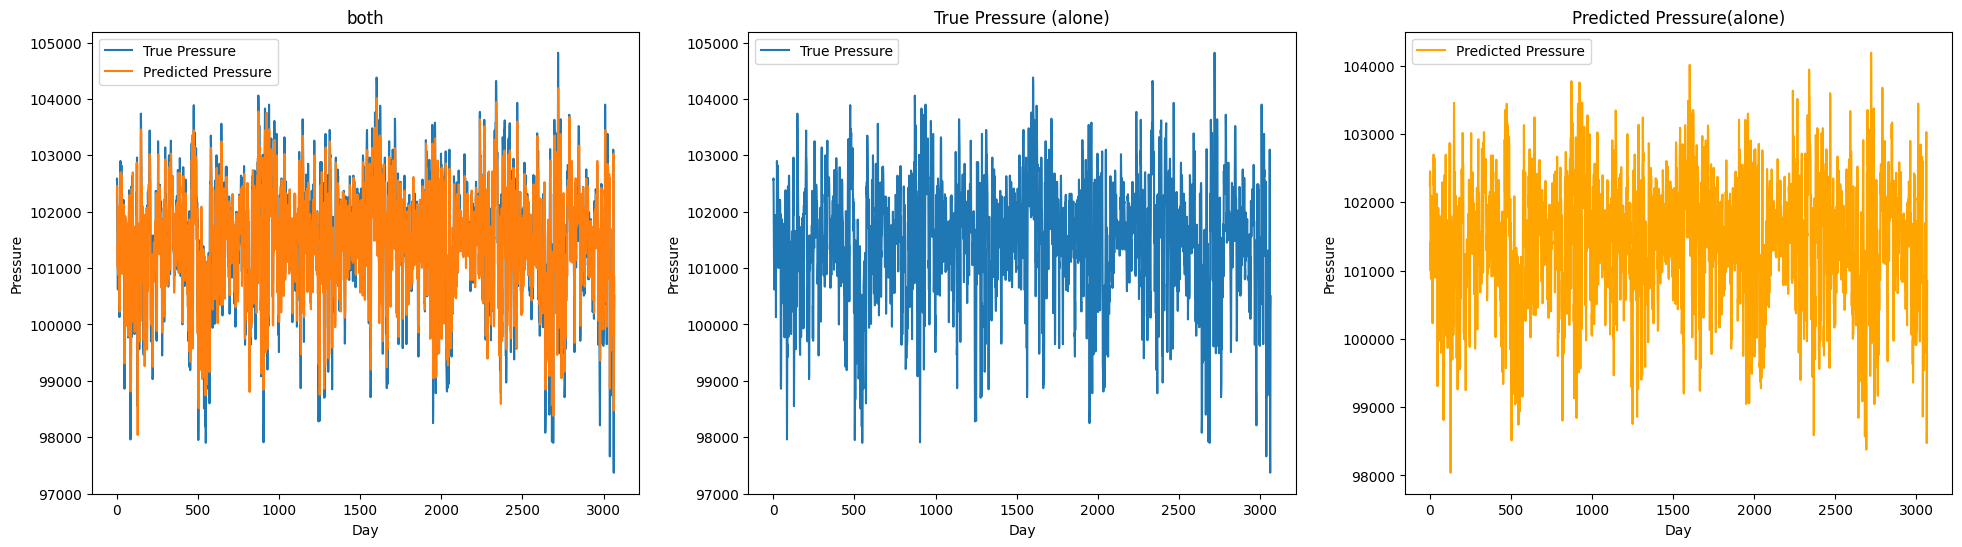

In [ ]:
#@title Pressure test predictions
plt.figure(figsize=(24, 6))

plt.subplot(131)
plt.title("both")
plt.plot(actual_pressure_test, label='True Pressure')
plt.plot(pressure_predictions, label='Predicted Pressure')
plt.xlabel('Day')
plt.ylabel('Pressure')
plt.legend()

plt.subplot(132)
plt.title("True Pressure (alone)")
plt.plot(actual_pressure_test, label='True Pressure')
plt.xlabel('Day')
plt.ylabel('Pressure')
plt.legend()

plt.subplot(133)
plt.title("Predicted Pressure(alone)")
plt.plot(pressure_predictions, label='Predicted Pressure',color='orange')
plt.xlabel('Day')
plt.ylabel('Pressure')
plt.legend()

plt.show()

In [ ]:
#@title Pressure prediction metrics
print("Pressure stats:")

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(pressure_predictions - actual_pressure_test))
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = np.mean((pressure_predictions - actual_pressure_test) ** 2)
print("Mean Squared Error (MSE):", mse)

print("Square root of the MSE is:", np.sqrt(mse))


# Calculate Mean Absolute Percentage Error (MAPE) with epsilon
epsilon = 1e-10

mape = np.mean(np.abs((pressure_predictions - actual_pressure_test) / (actual_pressure_test + epsilon))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

Pressure stats:
Mean Absolute Error (MAE): 419.91672277431127
Mean Squared Error (MSE): 301656.18628989
Square root of the MSE is: 549.2323609274039
Mean Absolute Percentage Error (MAPE): 0.41410039259386344
